<a href="https://colab.research.google.com/github/irfanshahmayeen/GR-08-CSE-445-Machine-Learnling-Stop-Sign-Detection-In-The-Street-/blob/Sadat/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Cell 1: Imports and Seed Setting
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss
import random




In [3]:
# Set a consistent random seed at the beginning of your notebook
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# Define dataset path and categories (replace with your actual paths and categories)
dataset_path = "/content/drive/MyDrive/project_445/Dataset"
categories = ["Non stop sign", "Stop sign"]
IMG_SIZE = 64


Preprocessing and Feature Extraction

In [4]:
# Data Loading, Preprocessing, and Augmentation

data = []
labels = []
original_images = []

# Load images for each category
for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    image_files = os.listdir(folder_path)
    print(f"Number of {category} images: {len(image_files)}")
    for filename in image_files:
        img_path = os.path.join(folder_path, filename)
        img_original = cv2.imread(img_path)
        original_images.append(img_original)
        img = cv2.resize(img_original, (IMG_SIZE, IMG_SIZE))
        data.append(img)
        labels.append(label)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Check class distribution
print(f"Class distribution: Non stop sign: {np.sum(labels == 0)}, Stop sign: {np.sum(labels == 1)}")

# Balance the dataset by undersampling the majority class
min_samples = min(np.sum(labels == 0), np.sum(labels == 1))
balanced_data = []
balanced_labels = []
balanced_originals = []

for label in [0, 1]:
    indices = np.where(labels == label)[0]
    np.random.shuffle(indices)
    selected_indices = indices[:min_samples]
    balanced_data.extend(data[selected_indices])
    balanced_labels.extend(labels[selected_indices])
    balanced_originals.extend([original_images[i] for i in selected_indices])

# Simple data augmentation: rotate and adjust brightness
augmented_data = []
augmented_labels = []
augmented_originals = []

for img, label, orig_img in zip(balanced_data, balanced_labels, balanced_originals):
    # Original image
    augmented_data.append(img)
    augmented_labels.append(label)
    augmented_originals.append(orig_img)

    # Rotate 10 degrees
    M = cv2.getRotationMatrix2D((IMG_SIZE/2, IMG_SIZE/2), 10, 1)
    rotated = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
    augmented_data.append(rotated)
    augmented_labels.append(label)
    augmented_originals.append(rotated)

    # Adjust brightness
    bright = cv2.convertScaleAbs(img, beta=20)
    augmented_data.append(bright)
    augmented_labels.append(label)
    augmented_originals.append(bright)

data = np.array(augmented_data)
labels = np.array(augmented_labels)
original_images = augmented_originals

print(f"Augmented dataset shape: {data.shape}")
print(f"Augmented class distribution: Non stop sign: {np.sum(labels == 0)}, Stop sign: {np.sum(labels == 1)}")

Number of Non stop sign images: 50
Number of Stop sign images: 50
Class distribution: Non stop sign: 50, Stop sign: 50
Augmented dataset shape: (300, 64, 64, 3)
Augmented class distribution: Non stop sign: 150, Stop sign: 150


Preprossed and feature extracted

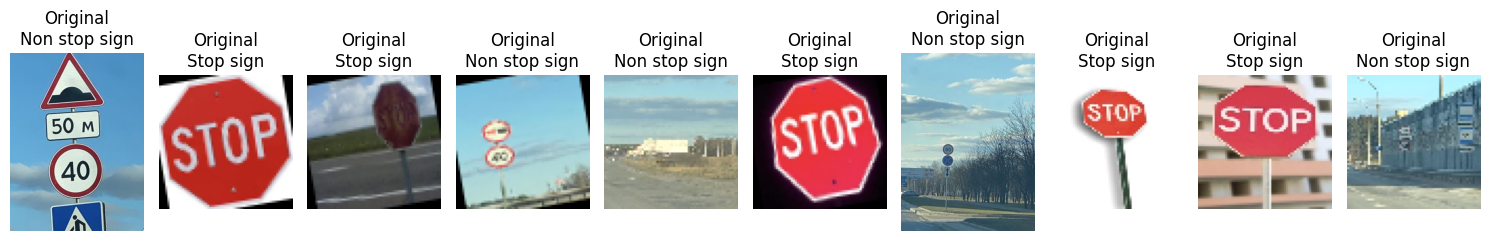

In [5]:
import matplotlib.pyplot as plt

num_images = 10
random_indices = np.random.choice(len(original_images), num_images, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_images, i + 1)
    original_rgb = cv2.cvtColor(original_images[idx], cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    plt.title(f"Original\n{categories[labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()



Hog feature

In [6]:
from skimage.feature import hog, local_binary_pattern

def extract_shape_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_contours = len(contours)
    largest_area = 0
    num_sides = 0
    is_circular = 0
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        largest_area = cv2.contourArea(largest_contour)
        approx = cv2.approxPolyDP(largest_contour, 0.01 * cv2.arcLength(largest_contour, True), True)
        num_sides = len(approx)
        # Check if the shape is circular (speed limit signs are often circular)
        perimeter = cv2.arcLength(largest_contour, True)
        area = cv2.contourArea(largest_contour)
        if perimeter > 0:
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            is_circular = 1 if circularity > 0.8 else 0  # Circularity close to 1 indicates a circle
    return np.array([num_contours, largest_area / (IMG_SIZE * IMG_SIZE), num_sides, is_circular])

features = []
for img in data:
    # Extract HOG features from grayscale image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray / 255.0
    hog_feat = hog(img_gray,
                   pixels_per_cell=(6, 6),
                   cells_per_block=(2, 2),
                   orientations=9,
                   feature_vector=True)

    # Extract color features (red and blue channels)
    red_channel = img[:, :, 2]
    red_hist = np.histogram(red_channel, bins=32, range=(0, 256))[0]
    red_hist = red_hist / red_hist.sum()

    blue_channel = img[:, :, 0]  # Blue channel in BGR
    blue_hist = np.histogram(blue_channel, bins=32, range=(0, 256))[0]
    blue_hist = blue_hist / blue_hist.sum()

    # Extract texture features using Local Binary Patterns (LBP)
    lbp = local_binary_pattern(img_gray * 255, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 26), density=True)

    # Extract shape features
    shape_feat = extract_shape_features(img)

    # Combine all features
    combined_features = np.concatenate([hog_feat, red_hist, blue_hist, lbp_hist, shape_feat])
    features.append(combined_features)

X_features = np.array(features)
print("Feature extraction completed. Shape:", X_features.shape)

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Feature extraction completed. Shape: (300, 3010)


Split the Dataset into Training, Validation, and Test Sets

Training samples: 240, Testing samples: 60
Training set label distribution: [121 119] (0: Non stop, 1: Stop)
Testing set label distribution: [29 31] (0: Non stop, 1: Stop)


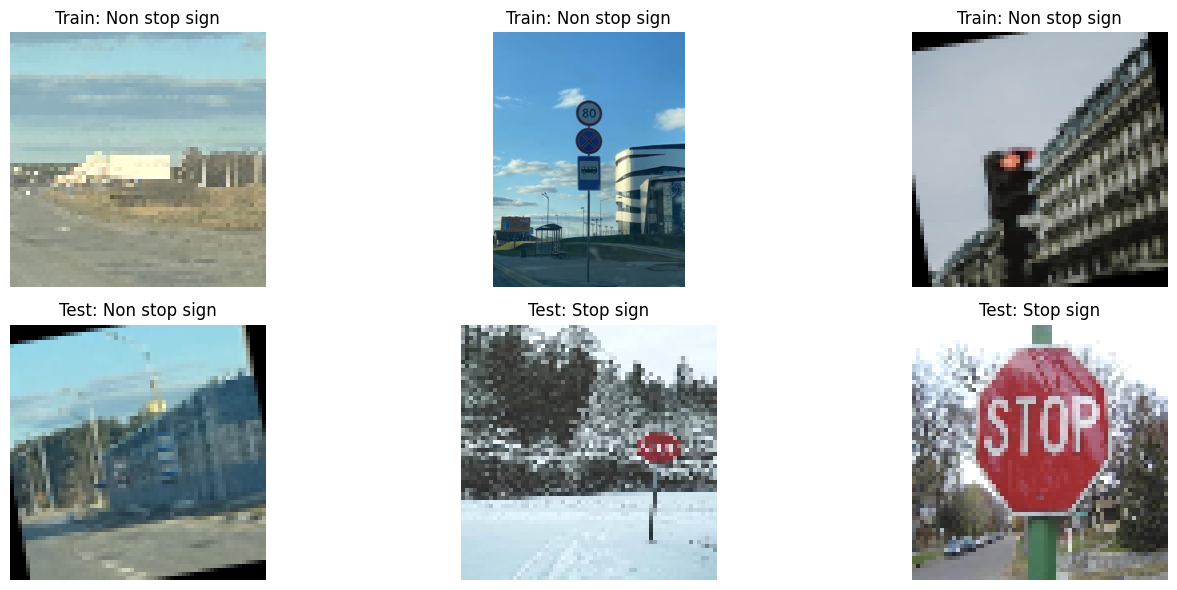

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, labels, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print(f"Training set label distribution: {np.bincount(y_train)} (0: Non stop, 1: Stop)")
print(f"Testing set label distribution: {np.bincount(y_test)} (0: Non stop, 1: Stop)")

num_samples = 3
train_indices = np.random.choice(len(X_train), num_samples, replace=False)
test_indices = np.random.choice(len(X_test), num_samples, replace=False)
X_full_indices = np.arange(len(X_features))
X_train_indices, X_test_indices = train_test_split(X_full_indices, test_size=0.2, random_state=42)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(train_indices):
    orig_idx = X_train_indices[idx]
    plt.subplot(2, num_samples, i + 1)
    original_rgb = cv2.cvtColor(original_images[orig_idx], cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    plt.title(f"Train: {categories[y_train[idx]]}")
    plt.axis('off')

for i, idx in enumerate(test_indices):
    orig_idx = X_test_indices[idx]
    plt.subplot(2, num_samples, i + num_samples + 1)
    original_rgb = cv2.cvtColor(original_images[orig_idx], cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    plt.title(f"Test: {categories[y_test[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

XGBoost Model Training

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate scale_pos_weight to give more weight to "Non stop sign" (class 0)
num_non_stop = np.sum(y_train == 0)
num_stop = np.sum(y_train == 1)
scale_pos_weight = (num_non_stop / num_stop) * 1.5  # Increase weight for "Non stop sign"

# Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=3,  # Reduce depth to prevent overfitting
    learning_rate=0.05,  # Lower learning rate for better generalization
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Model Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Feature importance analysis
feature_importance = xgb_model.feature_importances_
print("\nFeature Importance (Top 10):")
for i in np.argsort(feature_importance)[::-1][:10]:
    print(f"Feature {i}: {feature_importance[i]:.4f}")

XGBoost Model Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

Non stop sign       0.85      0.97      0.90        29
    Stop sign       0.96      0.84      0.90        31

     accuracy                           0.90        60
    macro avg       0.91      0.90      0.90        60
 weighted avg       0.91      0.90      0.90        60


Confusion Matrix:
[[28  1]
 [ 5 26]]

Feature Importance (Top 10):
Feature 2952: 0.0448
Feature 1208: 0.0288
Feature 1759: 0.0271
Feature 1487: 0.0247
Feature 1938: 0.0246
Feature 2967: 0.0186
Feature 2189: 0.0180
Feature 1440: 0.0177
Feature 2979: 0.0177
Feature 1495: 0.0172


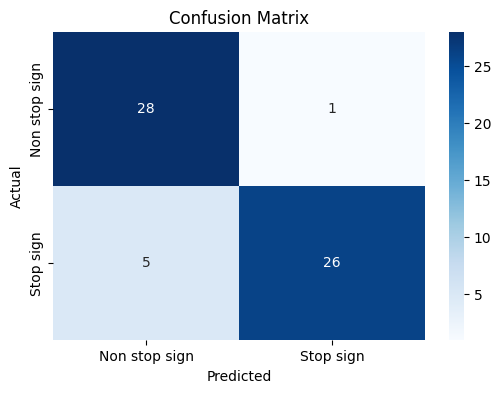

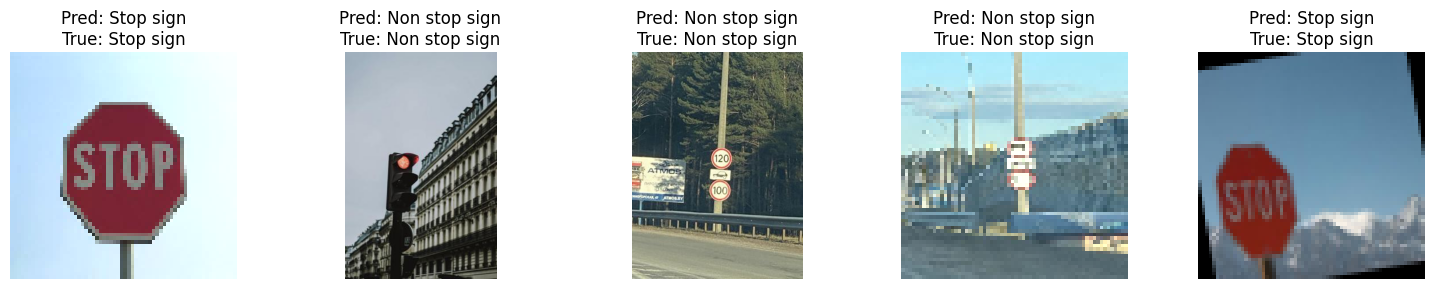

In [9]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

num_samples = 5
test_indices = np.random.choice(len(X_test), num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(test_indices):
    orig_idx = X_test_indices[idx]
    plt.subplot(1, num_samples, i + 1)
    original_rgb = cv2.cvtColor(original_images[orig_idx], cv2.COLOR_BGR2RGB)
    plt.imshow(original_rgb)
    pred_label = categories[y_pred[idx]]
    true_label = categories[y_test[idx]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    if pred_label != true_label:
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()

Testing


Testing image: /content/drive/MyDrive/project_445/Test images/Stop sign/1.jpg


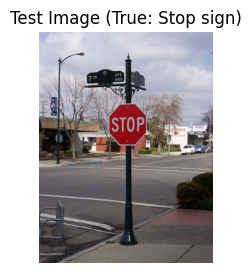

Prediction: Stop sign
Confidence scores: Non stop sign: 0.02, Stop sign: 0.98
Final Prediction: Stop sign

Testing image: /content/drive/MyDrive/project_445/Test images/Non stop sign/road135.jpg


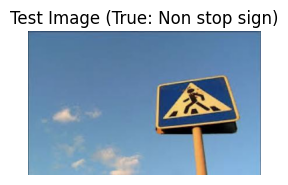

Prediction: Non stop sign
Confidence scores: Non stop sign: 0.94, Stop sign: 0.06
Final Prediction: Non stop sign


In [12]:
def predict_stop_sign(image_path, true_label):
    # Load the test image (handle PNG format)
    if image_path.lower().endswith('.png'):
        img = Image.open(image_path).convert('RGB')
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else:
        img = cv2.imread(image_path)

    if img is None:
        print(f"Error: Could not load image at {image_path}")
        return None

    # Display the test image for verification
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Test Image (True: {true_label})")
    plt.axis('off')
    plt.show()

    # Preprocess the image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Extract HOG features
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray / 255.0
    hog_feat = hog(img_gray,
                   pixels_per_cell=(6, 6),
                   cells_per_block=(2, 2),
                   orientations=9,
                   feature_vector=True)

    # Extract color features
    red_channel = img[:, :, 2]
    red_hist = np.histogram(red_channel, bins=32, range=(0, 256))[0]
    red_hist = red_hist / red_hist.sum()

    blue_channel = img[:, :, 0]
    blue_hist = np.histogram(blue_channel, bins=32, range=(0, 256))[0]
    blue_hist = blue_hist / blue_hist.sum()

    # Extract texture features (LBP)
    lbp = local_binary_pattern(img_gray * 255, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 26), density=True)

    # Extract shape features
    shape_feat = extract_shape_features(img)

    # Combine features
    img_features = np.concatenate([hog_feat, red_hist, blue_hist, lbp_hist, shape_feat])

    # Predict with threshold adjustment
    probabilities = xgb_model.predict_proba([img_features])[0]
    threshold = 0.4  # Lower threshold for "Stop sign" to favor "Non stop sign"
    prediction = 1 if probabilities[1] > threshold else 0

    print(f"Prediction: {categories[prediction]}")
    print(f"Confidence scores: Non stop sign: {probabilities[0]:.2f}, Stop sign: {probabilities[1]:.2f}")

    return categories[prediction]

# Test with multiple images
test_images = [
    ("/content/drive/MyDrive/project_445/Test images/Stop sign/1.jpg", "Stop sign"),
    ("/content/drive/MyDrive/project_445/Test images/Non stop sign/road135.jpg", "Non stop sign")
]
for test_image, true_label in test_images:
    print(f"\nTesting image: {test_image}")
    result = predict_stop_sign(test_image, true_label)
    if result:
        print("Final Prediction:", result)